# Real case: Underevaluated center back for a 3rd division french club 

---

### Objective
Identify an **undervalued center-back** who excels in aerial duels and defensive reliability, but remains off the radar

---

### Focus

We will follow this major criteria:

- The player salary should be less than 70% of median player in National 
- Search for **aerial** dominant players
- Low error leading to a goal conceded is a strong bonus
- High % successful pass is a bonus
- Young player is a bonus
- No age restriction, should be a starting player candidate 

In [219]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Charger les données nettoyées
df = pd.read_csv('../data/processed/cleaned_data.csv')

# Filter on the salary limit fixed by the club

In [220]:
# Get National players
national_players = df[df['Division']=='Championnat National']

# Calculate the median salary for a player in National
median_salary_national = national_players['Wage'].median()

# Club limit: 70% of median salary
club_limit = 0.7*median_salary_national
print('Club limit: ', club_limit)

# Filter on the salary limit
national_players_filtered = national_players[national_players['Wage'] <= club_limit]

# Create the dataframe with the players that are under the club limit, from every division
df_wage_filtered = df[(df['Wage'] <= club_limit) & (df['Position'].str.contains('D \\(C\\)'))]

# Display the number of players in the dataframe
print('Number of players in the dataframe: ', len(df_wage_filtered))


Club limit:  568.75
Number of players in the dataframe:  183


# Find out aerial dominant players

In [221]:

# Get the top 50 players with the highet aerial duels win rate
top_50_aerial_duels_win_rate = df_wage_filtered.sort_values(by='Headers Won/90', ascending=False).head(50)

# Get the top 50 players with the most aerial duels per 90
top_50_aerial_duels_per_90 = df_wage_filtered.sort_values(by='Aerial Duels/90', ascending=False).head(50)

# Find players that are in the both top lists
common_players = top_50_aerial_duels_win_rate[top_50_aerial_duels_win_rate['ID'].isin(top_50_aerial_duels_per_90['ID'])]

# Display the resulting dataframe
print('Number of players in both top 50 lists:', len(common_players))
common_players.head()

# Redo it by selecting the top 40 players, not 50
top_40_aerial_duels_win_rate = df_wage_filtered.sort_values(by='Headers Won/90', ascending=False).head(40)
top_40_aerial_duels_per_90 = df_wage_filtered.sort_values(by='Aerial Duels/90', ascending=False).head(40)

common_players_40 = top_40_aerial_duels_win_rate[top_40_aerial_duels_win_rate['ID'].isin(top_40_aerial_duels_per_90['ID'])]

# Display the resulting dataframe
print('Number of players in both top 40 lists:', len(common_players_40))



Number of players in both top 50 lists: 45
Number of players in both top 40 lists: 36


# KPI creation

In [222]:
# ADS - Aerial dominance score
df_wage_filtered['ADS'] = df_wage_filtered['Header Success %'] * np.log1p(df_wage_filtered['Aerial Duels']) # multiply by the volume in order to give more weight

# EDS - Error leading to a goal conceded
df_wage_filtered["EDS"] = 1 / (1 + df_wage_filtered["Errors Leading to Goal"])
 
# Passing Efficiency
df_wage_filtered["PE"] = df_wage_filtered["Pass Completion %"] / 100 * np.log1p(df_wage_filtered["Passes Attempted/90"])

# Playing time factor (minutes jouées)
df_wage_filtered["PT"] = np.log1p(df_wage_filtered["Minutes"]) / np.log1p(df_wage_filtered["Minutes"].max())

# Age bonus
df_wage_filtered["AB"] = ((27 - df_wage_filtered["Age"]).clip(lower=0)) / 10 #clip to avoid malus for players over 27

# Add the yellow and red cards per minute played
df_wage_filtered["YC"] = df_wage_filtered["Yellow Cards"] / df_wage_filtered["Minutes"] * 90
df_wage_filtered["RC"] = df_wage_filtered["Red Cards"] / df_wage_filtered["Minutes"] * 90
df_wage_filtered["Cards_per90"] = df_wage_filtered["YC"] + (3 * df_wage_filtered["RC"])   # red counts triple
df_wage_filtered["CP"] = 1 / (1 + df_wage_filtered["Cards_per90"]*5) 

# Score weights relevant with the given criteria
weights = {
    "ADS": 0.35, # Aerial dominance is crucial
    "EDS": 0.2, # Error minimization is important
    "PE": 0.1, # Passing efficiency is valuable
    "PT": 0.1, # Playing time shows reliability
    "AB": 0.15, # Age bonus for potential resale value
    "CP": 0.1, # Yellow card malus
}

df_wage_filtered["Moneyball Score"] = (
    df_wage_filtered["ADS"] * weights["ADS"] +
    df_wage_filtered["EDS"] * weights["EDS"] +
    df_wage_filtered["PE"] * weights["PE"] +
    df_wage_filtered["PT"] * weights["PT"] +
    df_wage_filtered["AB"] * weights["AB"] +
    df_wage_filtered["CP"] * (- weights["CP"]) # weight has negative effect 
)


# Sort the dataframe by the Moneyball Score
df_sorted = df_wage_filtered.sort_values(by="Moneyball Score", ascending=False)
moneyball_filtered = df_sorted[[
    "Name", "Club", "Division",  "Age",
    "Wage", "Header Success %", "Aerial Duels",
    "Errors Leading to Goal", "Pass Completion %",
    "Moneyball Score", 'ADS'
]]


# Display the top 10 players
print(moneyball_filtered.head(10))



                     Name             Club  \
3865       Sebastian Kosa   Spartak Trnava   
1702       Omri Gandelman  Maccabi Netanya   
3304         Ivan Ćalušić         Radomlje   
4271         Marko Jevtić      Mačva Šabac   
5185       Milenko Škorić    Radnički (SM)   
5305      Dušan Lalatović           FK Rad   
5605          Nikos Peios        Ergotelis   
4146    Yevhen Tsymbaliuk  Desna Chernihiv   
5117  Alexandros Masouras           Chania   
6278    Michael Ogungbaro              KTP   

                                  Division  Age   Wage  Header Success %  \
3865                          Fortuna Liga   18  425.0              0.83   
1702         Ligat Tel Aviv Stock Exchange   22  500.0              0.83   
3304            PrvaLiga Telekom Slovenije   22  150.0              0.81   
4271                      Prva liga Srbija   26  120.0              0.85   
5185                      Prva liga Srbija   30  230.0              0.87   
5305                      Prva liga S

/tmp/ipykernel_19978/2874772498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wage_filtered['ADS'] = df_wage_filtered['Header Success %'] * np.log1p(df_wage_filtered['Aerial Duels']) # multiply by the volume in order to give more weight
/tmp/ipykernel_19978/2874772498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wage_filtered["EDS"] = 1 / (1 + df_wage_filtered["Errors Leading to Goal"])
/tmp/ipykernel_19978/2874772498.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

# Shortlist and graphical representation

/tmp/ipykernel_19978/165379314.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


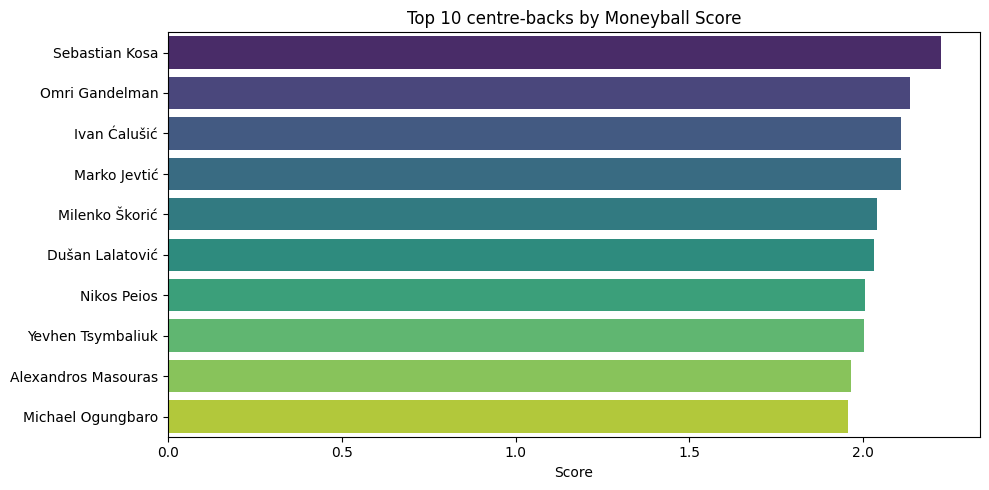

In [223]:
top10 = moneyball_filtered.head(10)
plt.figure(figsize=(10, 5))
sns.barplot(
    y="Name",
    x="Moneyball Score",
    data=top10,
    palette="viridis"
)
plt.title("Top 10 centre-backs by Moneyball Score")
plt.xlabel("Score")
plt.ylabel("")
plt.tight_layout()
plt.show()


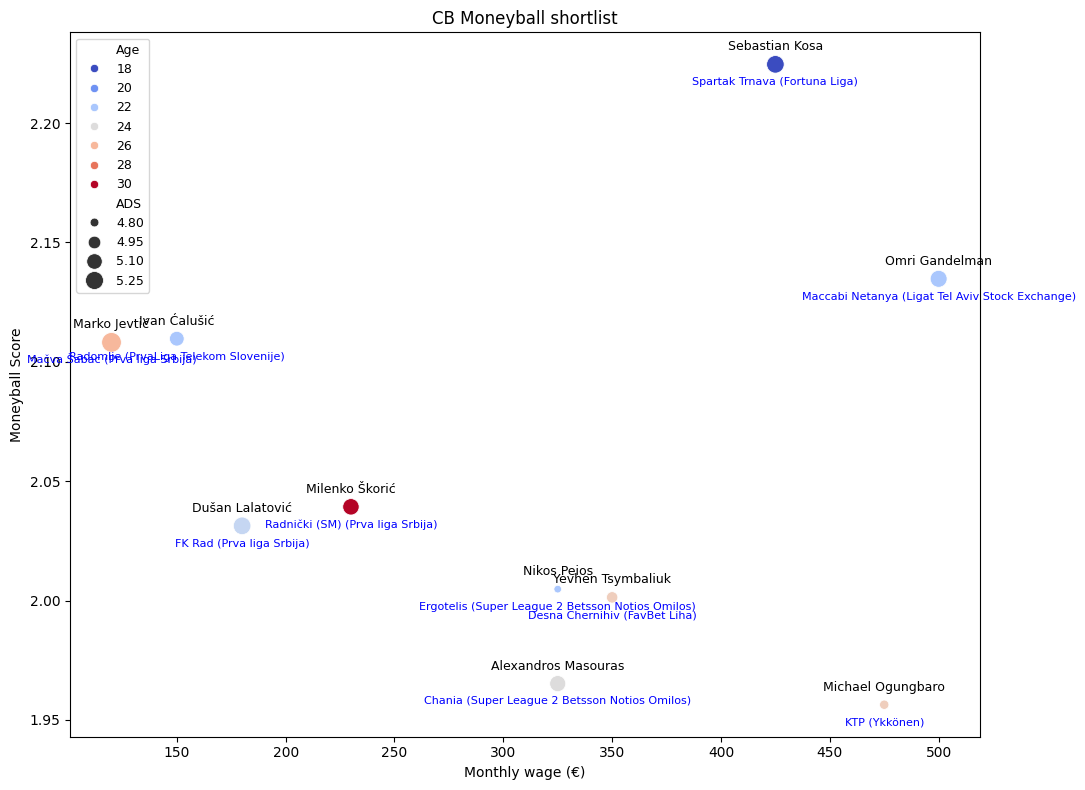

<Figure size 640x480 with 0 Axes>

In [224]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="Wage",
    y="Moneyball Score" ,
    hue="Age",
    size="ADS",
    sizes=(30, 200),
    palette="coolwarm",
    data=top10
)
plt.title("CB Moneyball shortlist")
plt.xlabel("Monthly wage (€)")
plt.ylabel("Moneyball Score")
plt.legend(loc="upper left",fontsize=9)
plt.tight_layout()
for i in range(len(top10)):
    player_name = top10.iloc[i]['Name']
    player_club = top10.iloc[i]['Club']
    player_division = top10.iloc[i]['Division']
    moneyball_score = top10.iloc[i]['Moneyball Score']
    wage = top10.iloc[i]['Wage']
    plt.annotate(
        player_name,
        (wage, moneyball_score),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=9,
        color='black'
    )
    plt.annotate(
        player_club + ' (' + player_division + ')',
        (wage, moneyball_score),
        textcoords="offset points",
        xytext=(0, -15),
        ha='center',
        fontsize=8,
        color='blue'
    )
plt.show()
plt.savefig('../outputs/cb_moneyball_shortlist.png', dpi=300, bbox_inches='tight')